# Description

I had an idea recently. Coming off the Santander competiton, whenever I saw 200 or 300 variables I start to think they're all I.I.D, lol. That gave me an idea regards to embeddings.

We're aware embeddings form a vector space where one can perform characteristic operations such as King - Male = Queen; however the **dimensions** of our embeddings are not linearly independent and actually overlap quite a bit, as evidenced by running, e.g. pearson correlation on them. What if during embedding generation, a penalty or regularization term was added which encouraged the columns to be linearly independent for the purpose of hopefully learning something different per dimension? Lets experiment.

In this kernel, we attempt to learn an embedding using CBOW (Word2Vec). First, we learn in per-usual and visualize the correlation coefficients matrix of each embedding dimension. As expected, there are a lot of correlations, which inform us that even if we've learned 10 or 300 dimensions, some of these dimensions may in fact be learning very similar relationships about our source words (undesireable). In the next block, we introduce a penalty into the loss function during training, which encourages our model to learn independent, non-correlated embedded features. In a follow up kernel, we'll pour the gas onto this model, train it with a larger corpus, and then test the performance of regular self-trained embeddings and lindep penalized self-trained embeddings on the previous Toxic Comment dataset!

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 2 words to the left, 2 to the right
CONTEXT_SIZE = 2
EMBEDDING_SIZE = 10

In [2]:
# The below CBOW implementation is based on a gist by xingjunjie (github @gavinxing), which in turn was based off of a template from http://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html.
class CBOW(nn.Module):
    def __init__(self, context_size=2, embedding_size=100, vocab_size=None):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear1 = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        lookup_embeds = self.embeddings(inputs)
        embeds = lookup_embeds.sum(dim=0)
        out = self.linear1(embeds)
        return out
    
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)

In [3]:
# Part of our loss function will be a penalty term.
# Pearson Correlation requires us to calculate Covariance:
def cov(m, y=None):
    if y is not None:
        m = torch.cat((m, y), dim=0)
    m_exp = torch.mean(m, dim=1)
    x = m - m_exp[:, None]
    cov = 1 / (x.size(1) - 1) * x.mm(x.t())
    return cov

def pcor(m, y=None):
    x = cov(m, y)
    
    # Not interested in positive nor negative correlations; 
    # We're only interested in correlation magnitudes:
    x = (x*x).sqrt() # no negs
    
    stddev = x.diag().sqrt()
    x = x / stddev[:, None]
    x = x / stddev[None, :]
    return x

def pcor_err(m, y=None):
    # Every var is correlated with itself, so subtract that:
    x = (pcor(m, y) - torch.eye(m.size(0)))
    return x.mean(dim=0).mean()

In [5]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = autograd.Variable(torch.LongTensor([word_to_ix[raw_text[i]]]))
    data.append((context, target))

In [12]:
def results(net, title):
    c = np.corrcoef(net.embeddings.weight.data.numpy().T)
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.imshow(c, interpolation='nearest')
    plt.show()
    print(np.abs(c).sum(), 'Feature Correlation Sum')

In [13]:
loss_func = nn.CrossEntropyLoss()

# No Penalty Version

In [14]:
net = CBOW(CONTEXT_SIZE, embedding_size=EMBEDDING_SIZE, vocab_size=vocab_size)
optimizer = optim.Adam(net.parameters()) #SGD?

for epoch in range(100):
    total_loss = 0
    for context, target in data:
        context_var = make_context_vector(context, word_to_ix)
        net.zero_grad()
        probs = net(context_var)

        loss = loss_func(probs.view(1,-1), target)
        loss.backward()
        optimizer.step()

        total_loss += loss.data
    print(total_loss)

tensor(265.3834)
tensor(252.9385)
tensor(242.8913)
tensor(233.5840)
tensor(224.9473)
tensor(216.8946)
tensor(209.3475)
tensor(202.2395)
tensor(195.5146)
tensor(189.1261)
tensor(183.0347)
tensor(177.2076)
tensor(171.6169)
tensor(166.2394)
tensor(161.0555)
tensor(156.0488)
tensor(151.2054)
tensor(146.5139)
tensor(141.9646)
tensor(137.5494)
tensor(133.2617)
tensor(129.0956)
tensor(125.0465)
tensor(121.1103)
tensor(117.2835)
tensor(113.5630)
tensor(109.9461)
tensor(106.4303)
tensor(103.0131)
tensor(99.6925)
tensor(96.4663)
tensor(93.3324)
tensor(90.2888)
tensor(87.3337)
tensor(84.4650)
tensor(81.6807)
tensor(78.9791)
tensor(76.3582)
tensor(73.8162)
tensor(71.3512)
tensor(68.9615)
tensor(66.6452)
tensor(64.4006)
tensor(62.2258)
tensor(60.1191)
tensor(58.0786)
tensor(56.1028)
tensor(54.1896)
tensor(52.3376)
tensor(50.5448)
tensor(48.8096)
tensor(47.1304)
tensor(45.5055)
tensor(43.9333)
tensor(42.4124)
tensor(40.9412)
tensor(39.5183)
tensor(38.1423)
tensor(36.8119)
tensor(35.5257)
tensor(34.2

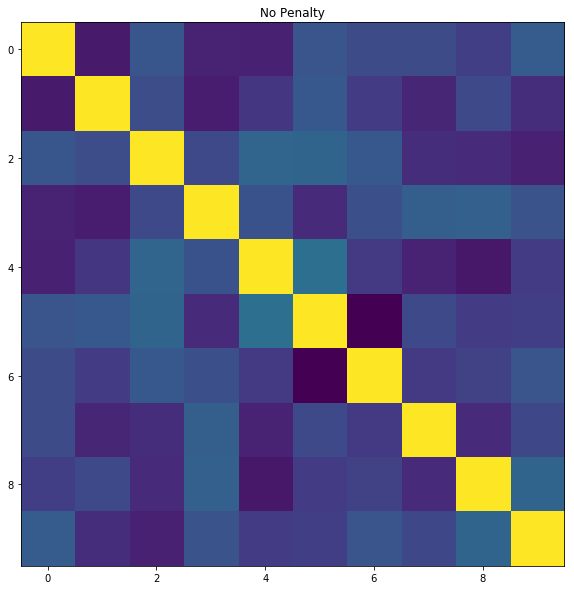

17.911736083080978 Feature Correlation Sum


In [15]:
results(net, 'No Penalty')

# Penalty Version

In [17]:
net = CBOW(CONTEXT_SIZE, embedding_size=EMBEDDING_SIZE, vocab_size=vocab_size)
optimizer = optim.Adam(net.parameters()) #SGD?

for epoch in range(100):
    total_loss = 0
    for context, target in data:
        context_var = make_context_vector(context, word_to_ix)
        net.zero_grad()
        probs = net(context_var)

        loss = loss_func(probs.view(1,-1), target) + pcor_err(torch.transpose(net.embeddings.weight,0,1)) * 6 # (vocab_size//2+1) ?
        loss.backward()
        optimizer.step()

        total_loss += loss.data
    print(total_loss)

tensor(293.5679)
tensor(279.3886)
tensor(267.7823)
tensor(256.8426)
tensor(246.4994)
tensor(236.8176)
tensor(227.7249)
tensor(219.1098)
tensor(210.9501)
tensor(203.2222)
tensor(195.8068)
tensor(188.7552)
tensor(182.1006)
tensor(175.7192)
tensor(169.5395)
tensor(163.5460)
tensor(157.7679)
tensor(152.1782)
tensor(146.7465)
tensor(141.5272)
tensor(136.5123)
tensor(131.6837)
tensor(127.1195)
tensor(122.7337)
tensor(118.4952)
tensor(114.4063)
tensor(110.4295)
tensor(106.5447)
tensor(102.7446)
tensor(99.0349)
tensor(95.4508)
tensor(91.9683)
tensor(88.6115)
tensor(85.3828)
tensor(82.2339)
tensor(79.1861)
tensor(76.2453)
tensor(73.3860)
tensor(70.6262)
tensor(67.9677)
tensor(65.4091)
tensor(62.9456)
tensor(60.5622)
tensor(58.2526)
tensor(56.0194)
tensor(53.8598)
tensor(51.7729)
tensor(49.7528)
tensor(47.8035)
tensor(45.9214)
tensor(44.1224)
tensor(42.4265)
tensor(40.7950)
tensor(39.2213)
tensor(37.7038)
tensor(36.2391)
tensor(34.8267)
tensor(33.5014)
tensor(32.2400)
tensor(31.0273)
tensor(29.8

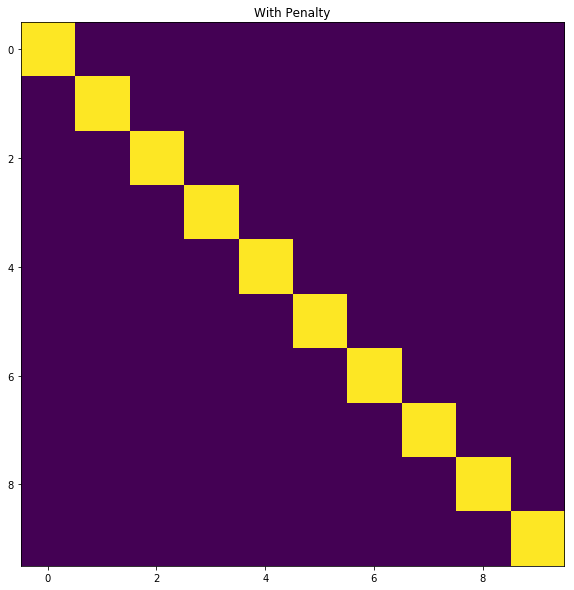

10.00420634144222 Feature Correlation Sum


In [18]:
results(net, 'With Penalty')

# Next Steps

Now that we have non-correlated embeddings, we need to dive deeper into EDA. Should we reduce the number of dimensions due to the removal of correlation? How well do these embeddings perform against their non-penalized counterparts? Just like with L1/L2/WD regularization schemes, penalizing too greatly can impact performance. We would need to identify an appropriate amount of penalty to tack on for best training results.